In [2]:
import geopandas as gpd
import pandas as pd
import locale
import shapely as shp
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import display, Markdown
pd.options.display.float_format = '{:.4f}'.format
pd.set_option('display.precision', 4)
locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Camadas UNB

sr_incra = gpd.read_file('../glebas-federais.gpkg', layer='sr_incra')
glebas_mais_amazonia = gpd.read_file('../glebas-federais.gpkg', layer='glebas-mais-amazonia')
glebas_centroid_menor_dist_sr = gpd.read_file('../glebas-federais.gpkg', layer='glebas-centroid-menor-dist-sr')
glebas_centroid_hub_menos_dist_sr = gpd.read_file('../glebas-federais.gpkg', layer='glebas-centroid-hub-menos-dist-sr')
glebas_centroid = gpd.read_file('../glebas-federais.gpkg', layer='glebas-centroid')
gleba_centroid_hub_sr = gpd.read_file('../glebas-federais.gpkg', layer='gleba-centroid-hub_sr')


In [13]:
# Unidades da Federação
# https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2022/Brasil/BR/BR_UF_2022.zip


estados = gpd.read_file('../UNB_ATUALIZAÇÃO/BR_UF_2022/BR_UF_2022.shp')
def uf_estudo(sigla):
    if sigla in ['AC', 'AM', 'AP', 'MA', 'MT', 'PA', 'RO', 'RR', 'TO']:
        return 1
    else:
        return 0
estados['amaz_legal'] = estados['SIGLA_UF'].apply(lambda x: uf_estudo(x))
estados.rename(str.lower, axis='columns', inplace=True)



In [16]:
uf_sigla = estados.loc[: , ['cd_uf', 'sigla_uf', 'amaz_legal']]
uf_sigla['cd_uf'] = uf_sigla['cd_uf'].astype(int)

In [17]:
uf_sigla.columns

Index(['cd_uf', 'sigla_uf', 'amaz_legal'], dtype='object')

In [18]:
# Municipios de estudo
# https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2022/Brasil/BR/BR_Municipios_2022.zip

municipios = gpd.read_file('../UNB_ATUALIZAÇÃO/BR_Municipios_2022/BR_Municipios_2022.shp')
municipios.rename(str.lower, axis='columns', inplace=True)
municipios = municipios[municipios['sigla_uf'].isin(['AC', 'AM', 'AP', 'MA', 'MT', 'PA', 'RO', 'RR', 'TO'])]
municipios['x'] = shp.get_x(municipios.centroid)
municipios['y'] = shp.get_y(municipios.centroid)


In [19]:
# Faixa de Fronteira
# https://geoftp.ibge.gov.br/organizacao_do_territorio/estrutura_territorial/municipios_da_faixa_de_fronteira/2022/Faixa_de_Fronteira_por_UF_2022_shp.zip

fronteira = gpd.read_file('../UNB_ATUALIZAÇÃO/Faixa_de_Fronteira_por_UF_2022_shp/Faixa_de_Fronteira_por_UF_2022.shp')
fronteira.rename(str.lower, axis='columns', inplace=True)



In [20]:
# Área de Estudo
# Fusão dos polígonos dos estados

area_estudo = estados[estados['amaz_legal']==1].dissolve()


In [ ]:
# Floresta Publica
# https://mmabr-my.sharepoint.com/:u:/g/personal/10810147769_mma_gov_br/EdkDvfzdlpJAneLK56geXAUBq-Pu8pCB5FTrLrD4WOUqnA?e=2fK6JC
# O arquivo está dividido por UF, assim, selecionaremos os da área de estudo e juntamos

floresta = gpd.read_file(f'../UNB_ATUALIZAÇÃO/CNFP 2022 - Shapefiles/CNFP_2022_AC.shp')

for uf in ['AM', 'AP', 'MA', 'MT', 'PA', 'RO', 'RR', 'TO']:
    floresta_uf = gpd.read_file(f'../UNB_ATUALIZAÇÃO/CNFP 2022 - Shapefiles/CNFP_2022_{uf}.shp')
    floresta = floresta.merge(floresta_uf)
floresta.columns = map(str.lower, floresta.columns)


<Axes: >

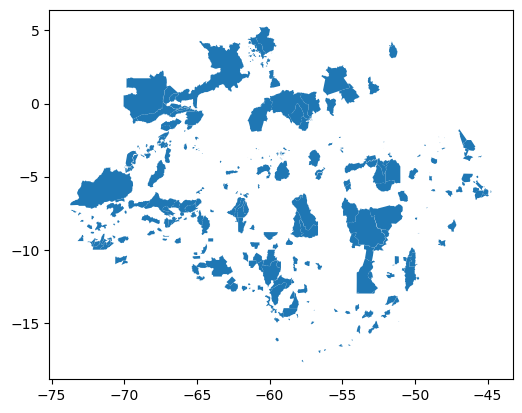

In [ ]:
# Terra Indígena
# https://geoserver.funai.gov.br/geoserver/Funai/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=Funai%3Atis_poligonais_portarias&maxFeatures=10000&outputFormat=application%2Fvnd.google-earth.kml%2Bxml
# O arquivo vem no formato KML tendo que ser transformado no QGIS para shapefile SIRGAS2000

indigena = gpd.read_file('../UNB_ATUALIZAÇÃO/tis_amazonia_legal_poligonais/tis_poligonais_portarias.shp', 
                         encoding='windows-1252', mask=area_estudo)

In [ ]:
# Unidade de conservação
# site: https://dados.gov.br/dados/conjuntos-dados/unidadesdeconservacao
# Selecionado no carregamento para a intersecção com a área de estudo
unidades_conserv = gpd.read_file('../UNB_ATUALIZAÇÃO/shp_cnuc_2024_02/cnuc_2024_02.shp', mask=area_estudo)

In [ ]:
# Território Quilombola
'''
# colunas: ['cd_quilomb', 'cd_sr', 'nr_process', 'nm_comunid', 'nm_municip',
       'cd_uf', 'dt_publica', 'dt_public1', 'nr_familia', 'dt_titulac',
       'nr_area_ha', 'nr_perimet', 'cd_sipra', 'ob_descric', 'st_titulad',
       'dt_decreto', 'tp_levanta', 'nr_escalao', 'area_calc_', 'perimetro_',
       'esfera', 'fase', 'responsave', 'geometry']
'''
tq = gpd.read_file('../UNB_ATUALIZAÇÃO/Áreas de Quilombolas/Áreas de Quilombolas.shp', mask=area_estudo)

Index(['cd_quilomb', 'cd_sr', 'nr_process', 'nm_comunid', 'nm_municip',
       'cd_uf', 'dt_publica', 'dt_public1', 'nr_familia', 'dt_titulac',
       'nr_area_ha', 'nr_perimet', 'cd_sipra', 'ob_descric', 'st_titulad',
       'dt_decreto', 'tp_levanta', 'nr_escalao', 'area_calc_', 'perimetro_',
       'esfera', 'fase', 'responsave', 'geometry'],
      dtype='object')

In [42]:
# Projeto de Assentamento
'''
# colunas: ['cd_sipra', 'uf', 'nome_proje', 'municipio', 'area_hecta', 'capacidade',
       'num_famili', 'fase', 'data_de_cr', 'forma_obte', 'data_obten',
       'area_calc_', 'sr', 'descricao_', 'geometry']
'''
pa = gpd.read_file('../UNB_ATUALIZAÇÃO/Assentamento Brasil/Assentamento Brasil.shp', mask=area_estudo)


# SIGEF

sigef = gpd.read_file('../UNB_ATUALIZAÇÃO/tb_sigef_geral/tb_sigef_geral.gpkg', layer='tb_sigef_geral', mask=area_estudo)
sigef = sigef.dropna(subset=['uf_id'])
sigef['uf_id'] = sigef['uf_id'].astype('int')
sigef = sigef.merge(uf_sigla, left_on='uf_id', right_on='cd_uf')
sigef = sigef.drop(['cd_uf', 'fid'], axis=1)



In [ ]:
# SNCI
'''
['num_proces', 'sr', 'num_certif', 'data_certi', 'qtd_area_p',
       'cod_profis', 'cod_imovel', 'nome_imove', 'uf_municip', 'geometry']

# colunas: ['id1', 'nome_imove', 'nome_inter', 'cod_imovel', 'matricula_',
       'num_proces', 'sr', 'uf_municip', 'cod_projet', 'cod_profis',
       'num_certif', 'data_certi', 'num_art', 'qtd_area_p', 'ind_atuali',
       'area_ha', 'geometry']
'''
snci = gpd.read_file('../UNB_ATUALIZAÇÃO/Imóvel certificado SNCI Privado/Imóvel certificado SNCI Privado.shp', mask=area_estudo)
snci['area_ha'] = snci.to_crs(5880).area/10000
snci['amaz_legal'] = snci['uf_municip'].apply(lambda x: uf_estudo(x))

Index(['num_proces', 'sr', 'num_certif', 'data_certi', 'qtd_area_p',
       'cod_profis', 'cod_imovel', 'nome_imove', 'uf_municip', 'geometry'],
      dtype='object')

In [62]:
# Criar o GPKG
gpd.GeoDataFrame(sr_incra).to_file('glebas-federais.gpkg', 
                                    layer=f'sr_incra',
                                    driver="GPKG")
gpd.GeoDataFrame(glebas_mais_amazonia).to_file('glebas-federais.gpkg', 
                                    layer=f'glebas-mais-amazonia',
                                    driver="GPKG")
gpd.GeoDataFrame(glebas_centroid_menor_dist_sr).to_file('glebas-federais.gpkg', 
                                    layer=f'glebas-centroid-menor-dist-sr',
                                    driver="GPKG")
gpd.GeoDataFrame(glebas_centroid_hub_menos_dist_sr).to_file('glebas-federais.gpkg', 
                                    layer=f'glebas-centroid-hub-menos-dist-sr',
                                    driver="GPKG")
gpd.GeoDataFrame(glebas_centroid).to_file('glebas-federais.gpkg', 
                                    layer=f'glebas-centroid',
                                    driver="GPKG")
gpd.GeoDataFrame(gleba_centroid_hub_sr).to_file('glebas-federais.gpkg', 
                                    layer=f'gleba-centroid-hub_sr',
                                    driver="GPKG")
gpd.GeoDataFrame(estados).to_file('glebas-federais.gpkg', 
                                    layer=f'uf-brasil',
                                    driver="GPKG")
gpd.GeoDataFrame(indigena).to_file('glebas-federais.gpkg', 
                                    layer='ti-portarias',
                                    driver='GPKG')
gpd.GeoDataFrame(floresta).to_file('glebas-federais.gpkg', 
                                    layer='florestas-publicas',
                                    driver='GPKG')
gpd.GeoDataFrame(area_estudo).to_file('glebas-federais.gpkg', 
                                    layer='area-estudo',
                                    driver='GPKG')
gpd.GeoDataFrame(fronteira).to_file('glebas-federais.gpkg', 
                                    layer='faixa-fronteira-150km',
                                    driver='GPKG')
gpd.GeoDataFrame(municipios).to_file('glebas-federais.gpkg', 
                                    layer=f'municipios-area-estudo',
                                    driver="GPKG")
gpd.GeoDataFrame(pa).to_file('glebas-federais.gpkg', 
                                    layer=f'pa-brasil',
                                    driver="GPKG")
gpd.GeoDataFrame(tq).to_file('glebas-federais.gpkg', 
                                    layer=f'tq-brasil',
                                    driver="GPKG")
gpd.GeoDataFrame(unidades_conserv).to_file('glebas-federais.gpkg', 
                                    layer=f'uc',
                                    driver="GPKG")
gpd.GeoDataFrame(snci).to_file('glebas-federais.gpkg', 
                                    layer=f'snci-particular',
                                    driver="GPKG")
